### this file has: Original Fitting Function + Updated Guesses (USE THIS VERSION)

In [1]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [2]:
#sga ids identified as possible good rot curves:
sga_ids = [9769, 11977, 12892, 14501, 16383, 19235, 19278, 25532, 30149, 31220, 32484, 36904, 37543, 46327, 58617, 73111, 88963, 91660, 90791, 106536, 
           114405, 114489, 122580, 126630, 125611, 128163, 128411, 130766, 149502, 153504, 175220, 176736, 184044, 186239, 189685, 188525, 190308, 
           192158, 196470, 199038, 202236, 205028, 209429, 212382, 218773, 235556, 254532, 272164, 272562, 276638, 288715, 289743, 291766, 300446, 
           302062, 305831, 309378, 319942, 330678, 349027, 349346, 363344, 373692, 378842, 384420, 389177, 393190, 395070, 398443, 398532, 416531, 
           431242, 430161, 432294, 450689, 450566, 455486, 457147, 458798, 462867, 466872, 467582, 471327, 469868, 471893, 473436, 477805, 481956, 
           485800, 493017, 507499, 526710, 544419, 544810, 544799, 544943, 548724, 548848, 550458, 564440, 569298, 568664, 570086, 582248, 591927, 
           607528, 608015, 629144, 630029, 630390, 635043, 638386, 641578, 643231, 643845, 644940, 647966, 649753, 649960, 651096, 654469, 659599, 
           663463, 671301, 671533, 694525, 696291, 696345, 706579, 720480, 722142, 726854, 728327, 729726, 729754, 736449, 742167, 743030, 744650, 
           752683, 757313, 757166, 758123, 759261, 759003, 766672, 783693, 793633, 804643, 805225, 819754, 820598, 823301, 824225, 826809, 827949, 
           833961, 833981, 843065, 843126, 845052, 887433, 901663, 901980, 908818, 908978, 911046, 914975, 914909, 916161, 920806, 923400, 925923, 
           925354, 928810, 928876, 932984, 947709, 953644, 957521, 957850, 967351, 968864, 971635, 975775, 972260, 977015, 976853, 979168, 978708, 
           989040, 989244, 1001302, 1003319, 1008726, 1014959, 1018187, 1021462, 1026141, 1031898, 1033651, 1033344, 1050173, 1065602, 1073430, 
           1086934, 1087039, 1087374, 1090772, 1091806, 1096564, 1098043, 1103477, 1111824, 1117018, 1124386, 1143335, 1146354, 1161160, 1167691, 
           1171841, 1179377, 1184894, 1184912, 1186034, 1187240, 1188032, 1188617, 1188926, 1193015, 1191665, 1194588, 1194958, 1199020, 1199539, 
           1201319, 1203786, 1204237, 1206707, 1218166, 1219319, 1254154, 1264056, 1264591, 1267967, 1271477, 1271549, 1272700, 1273605, 1278144, 
           1281619, 1282407, 1285273, 1286710, 1289613, 1293967, 1301768, 1304908, 1335916, 1338866, 1345100, 1348956, 1349555, 1354266, 1355575, 
           1361363, 1361399, 1365519, 1365549, 1367137, 1368018, 1368443, 1374964, 1379143, 1405053, 1429680, 1434487]

In [2]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/'
v_dir = '/pscratch/sd/j/jjpim/rotcurves/'
hist_dir = '/pscratch/sd/j/jjpim/'

# load updated fuji table
tf_fuji = Table.read(data_dir + 'SV/desi_pv_tf_fuji_healpix_rotcurve_EOA_VI_velocity.fits') 
# load iron table
tf_iron = Table.read(data_dir + 'Y1/desi_pv_tf_iron_healpix_rotcurve_EOA_VI_velocity.fits')
#combine
tf_mastertable = vstack([tf_fuji,tf_iron])
#unique SGA IDs in rot curve galaxies
tf_galaxies = np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1])
tf_mastertable_dict = {}
for sga_id in np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1]):
    tf_mastertable_dict[sga_id] = np.where(tf_mastertable['SGA_ID'] == sga_id)[0]

# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

In [3]:
#new columns
tf_mastertable['ROTCURVE_CHI2']=np.nan
tf_mastertable['VMAX']=np.nan
tf_mastertable['VMAX_ERR']=np.nan
tf_mastertable['RTURN']=np.nan
tf_mastertable['RTURN_ERR']=np.nan
tf_mastertable['ALPHA']=np.nan
tf_mastertable['ALPHA_ERR']=np.nan
tf_mastertable['INCLINATION']=np.nan

In [4]:
def inclination_angle(axis_ratio):
    '''
    Calculate Inclination Angle
    Parameters
    ----------
    axis_ratio : float
        Axis ratio for galaxy.
        
    Returns
    -------
    Inclination angle in Radians
    '''
    cos_i2 = (axis_ratio ** 2 - 0.2 ** 2)/(1 - 0.2 ** 2)
    if cos_i2 < 0:
        cos_i2 = 0.001
    inclination = np.arccos(cos_i2 ** 0.5)
    return inclination

In [5]:
def v_rot(r, v_max, r_turn, alpha):
    '''
    Calculate Rotational Velocity at a target
    Parameters
    ----------
    r : float
        Target distance.
    v_max : float
        Maximum velocity.
    r_turn: float
        Velocity curve turning point.
    alpha : 
        Velocity curve angle.
    Returns
    -------
    Rotational velocity in km / s
    '''
    vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
    return vrot

In [6]:
def chi_2(params, v, v_err, r):
    '''
    Calculate Chi Squared 
    Parameters
    ----------
    params : list
        v_max, r_turn, alpha.
    v : float
        Absolute value of velocity.
    v_err : float
        Uncertainty for velocity.
    r : 
        Target distance.
    Returns
    -------
    Chi Squared value
    '''
    v_max, r_turn, alpha = params
    v_model = v_rot(r, v_max, r_turn, alpha)
    chi_sq = np.sum((v_model - v)**2/(v_err**2))
    return chi_sq

In [ ]:
#loop through all plottables
for sga_id in sga_ids:
    sga_idx = SGA_dict[sga_id]
    axis_ratio = SGA['BA'][sga_idx]
    
    #calculate inclination and assign to table
    inc = inclination_angle(axis_ratio)
    tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = inc
    
    #velocty cut <= 1000 and define parameters
    v = np.abs(tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VELOCITY'])
    verr = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VERR']
    radius = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['SKY_FIBER_DIST_R26']
    
    #calculate rotational velocity and error adjusted for inclination
    vrotate = v / (np.sin(inc))
    vrot = vrotate[np.abs(vrotate) <= 1000]
    vrotate_err = verr / (np.sin(inc))
    vrot_err = vrotate_err[np.abs(vrotate) <= 1000]
    r = radius[np.abs(vrotate) <= 1000]
    
    #initial guesses and bounds
    alpha_guess = 2
    alpha_low = 0.001
    alpha_high = 100
    v_max_guess = np.max(vrot)
    v_max_low = 10
    v_max_high = 5100
    r_turn_guess = 0.3
    r_turn_low = 0.01
    r_turn_high = 1
    
    #put guesses and bounds into array / tuples to pass into functions
    guess = [v_max_guess, r_turn_guess, alpha_guess]
    bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), (alpha_low, alpha_high)]
    
    #define result
    result = minimize(chi_2, guess, method = 'Powell', args=(vrot, vrot_err, r), bounds=bounds)
    
    #plot only if result succeeds
    if result.success:
        #calculating errors
        hessian = ndt.Hessian(chi_2)
        hess = hessian(result.x, vrot, vrot_err, r)
        np.save('/pscratch/sd/j/jjpim/hessians/' + str(sga_id) + '_hessian.npy', hess)
        try:
            hess_inv = 2*np.linalg.inv(hess)
            fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))
        except np.linalg.LinAlgError:
            fit_params_err = np.nan*np.ones(len(result.x))

        #adding results into table
        tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[0]
        tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[1]
        tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[2]
        #chi_normal = result.fun/(len(v)-3)
        tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.fun
        
        #adding errors to mastertable
        tf_mastertable['VMAX_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[0]
        tf_mastertable['RTURN_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[1]
        tf_mastertable['ALPHA_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[2]
        
        #create and index linear space
        rs = np.linspace(0, 1.1, 1000)
        vs = v_rot(rs, result.x[0], result.x[1], result.x[2])
            

        if not np.isnan(fit_params_err).all():
            N_samples = 10000
            try:
                random_sample = np.random.multivariate_normal(mean=[result.x[0],
                                                            result.x[1],
                                                            result.x[2]],
                                                            cov=hess_inv,
                                                            size=N_samples)
            except:
                print(str(sga_id) + ' plot sample failed')
            
            #cuts out bad samples in gaussian
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]
        
        
            y_sample = np.zeros((len(rs), len(good_randoms[:,0])))
            for i in range(len(rs)):
                for j in range(len(good_randoms[:,0])):
            # Calculate values of curve at this location
                    y_sample[i][j] = v_rot(rs[i], good_randoms[:,0][j],
                                             good_randoms[:,1][j],
                                             good_randoms[:,2][j])
        
            #standard dev along axis of parameter variances
            stdevs = np.nanstd(y_sample, axis=1)   
        
            plt.fill_between(rs, vs - stdevs, vs + stdevs, facecolor='greenyellow', alpha=0.2)
        
        plt.errorbar(r, vrot, yerr=vrot_err, linestyle='none', marker='o', color='g')
        plt.plot(rs, vs, color='greenyellow')
        plt.xlabel(r"r/$R_{26}$")
        plt.ylabel("Velocity [km/s]")
        plt.title("SGA ID "+str(sga_id)+ " Rotation Curve")
        img_name = v_dir + '{}.jpg'.format(sga_id)
        plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
        plt.show()
        plt.close()
        
        print(fit_params_err)

In [ ]:
#Nitya's MaNGA data, use to determine good alpha bounds
fits_file = '/global/homes/j/jjpim/H_alpha_HIvel_BB_refit_ba.fits'
table = Table.read(fits_file, hdu=1)

table

In [ ]:
alpha_values = table['alpha']
alpha_values_clean = alpha_values[~np.isnan(alpha_values)]

# calculate bin width and number of bins w/ freedman-diaconis rule
q75, q25 = np.percentile(alpha_values_clean, [75, 25])
iqr = q75 - q25
fd_bin_width = 2 * iqr / np.cbrt(len(alpha_values_clean))
fd_bins = int((max(alpha_values_clean) - min(alpha_values_clean)) / fd_bin_width)

counts, bin_edges = np.histogram(alpha_values_clean, bins=fd_bins)

# find peak
max_count_index = np.argmax(counts)
peak_bin_left_edge = bin_edges[max_count_index]
peak_bin_right_edge = bin_edges[max_count_index + 1]
peak_bin_center = (peak_bin_left_edge + peak_bin_right_edge) / 2

# find 70th percentile
percentile_70th = np.percentile(alpha_values_clean, 70)

# histogram!
plt.figure()
plt.hist(alpha_values_clean, bins=fd_bins, color='#87c9e8', edgecolor='black', alpha=0.7)

# axis and labels
plt.xlim(0, 10)
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.title(f'Histogram of MaNGA Alpha Values')

# line at peak
plt.axvline(peak_bin_center, color='red', linestyle='--', label=f'Peak: {peak_bin_center:.2f}')

# line at 70th percentile
plt.axvline(percentile_70th, color='blue', linestyle='--', label=f'70th Percentile: {percentile_70th:.2f}')
plt.legend()
plt.savefig(hist_dir + 'MaNGA_alpha_hist.png', dpi=120)
plt.show()

In [12]:
bad_sga_ids = [ 1001302, 1003319, 1008726, 1014959, 1018187, 1021462, 1050173, 106536, 1065602, 1073430, 1086934, 1087039, 1087374, 
           1090772, 1091806, 1096564, 1111824, 1117018, 1124386, 1143335, 114405, 114489, 1146354, 1167691, 1171841, 1184894, 1184912, 
           1186034, 1187240, 1188032, 1191665, 1194588, 11977, 1199020, 1206707, 1218166, 1219319, 122580, 1264056, 1271549, 1272700, 
           1278144, 1282407, 12892, 1289613, 1293967, 130766, 1335916, 1345100, 1355575, 1361363, 1361399, 1367137, 1368018, 1368443, 
           1374964, 1379143, 1405053, 1434487, 176736, 184044, 188525, 189685, 19235, 199038, 212382, 254532, 272164, 272562, 276638, 
           288715, 289743, 291766, 305831, 319942, 330678, 349027, 384420, 416531, 431242, 432294, 455486, 457147, 46327, 466872, 
           467582, 471327, 477805, 5002047, 507499, 526710, 544810, 544943, 548724, 550458, 564440, 568664, 569298, 570086, 582248, 
           58617, 591927, 607528, 630029, 630390, 635043, 641578, 643845, 644940, 647966, 649960, 659599, 671301, 671533, 696291, 
           696345, 726854, 729754, 742167, 743030, 752683, 757166, 757313, 758123, 793633, 804643, 805225, 819754, 823301, 824225, 
           826809, 833961, 833981, 843065, 845052, 88963, 901980, 908978, 914909, 916161, 91660, 920806, 923400, 925354, 925923, 
           928876, 932984, 947709, 953644, 957521, 957850, 967351, 968864, 972260, 975775, 976853, 9769, 977015, 978708, 979168, 989244 ]

In [ ]:
#loop through all plottables
for sga_id in bad_sga_ids:
    sga_idx = SGA_dict[sga_id]
    axis_ratio = SGA['BA'][sga_idx]
    
    #calculate inclination and assign to table
    inc = inclination_angle(axis_ratio)
    tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = inc
    
    #velocty cut <= 1000 and define parameters
    v = np.abs(tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VELOCITY'])
    verr = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VERR']
    radius = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['SKY_FIBER_DIST_R26']
    
    #calculate rotational velocity and error adjusted for inclination
    vrotate = v / (np.sin(inc))
    vrot = vrotate[np.abs(vrotate) <= 1000]
    vrotate_err = verr / (np.sin(inc))
    vrot_err = vrotate_err[np.abs(vrotate) <= 1000]
    r = radius[np.abs(vrotate) <= 1000]
    
    #initial guesses and bounds
    alpha_guess = 2
    alpha_low = 0.001
    alpha_high = 4
    v_max_guess = np.max(vrot)
    v_max_low = 10
    v_max_high = 5100
    r_turn_guess = 0.3
    r_turn_low = 0.01
    r_turn_high = 1
    
    #put guesses and bounds into array / tuples to pass into functions
    guess = [v_max_guess, r_turn_guess, alpha_guess]
    bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), (alpha_low, alpha_high)]
    
    #define result
    result = minimize(chi_2, guess, method = 'Powell', args=(vrot, vrot_err, r), bounds=bounds)
    
    #plot only if result succeeds
    if result.success:
        #calculating errors
        hessian = ndt.Hessian(chi_2)
        hess = hessian(result.x, vrot, vrot_err, r)
        np.save('/pscratch/sd/j/jjpim/hessians/' + str(sga_id) + '_hessian.npy', hess)
        try:
            hess_inv = 2*np.linalg.inv(hess)
            fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))
        except np.linalg.LinAlgError:
            fit_params_err = np.nan*np.ones(len(result.x))

        #adding results into table
        tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[0]
        tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[1]
        tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[2]
        #chi_normal = result.fun/(len(v)-3)
        tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.fun
        
        #adding errors to mastertable
        tf_mastertable['VMAX_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[0]
        tf_mastertable['RTURN_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[1]
        tf_mastertable['ALPHA_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[2]
        
        #create and index linear space
        rs = np.linspace(0, 1.1, 1000)
        vs = v_rot(rs, result.x[0], result.x[1], result.x[2])
            

        if not np.isnan(fit_params_err).all():
            N_samples = 10000
            try:
                random_sample = np.random.multivariate_normal(mean=[result.x[0],
                                                            result.x[1],
                                                            result.x[2]],
                                                            cov=hess_inv,
                                                            size=N_samples)
            except:
                print(str(sga_id) + ' plot sample failed')
            
            #cuts out bad samples in gaussian
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]
        
        
            y_sample = np.zeros((len(rs), len(good_randoms[:,0])))
            for i in range(len(rs)):
                for j in range(len(good_randoms[:,0])):
            # Calculate values of curve at this location
                    y_sample[i][j] = v_rot(rs[i], good_randoms[:,0][j],
                                             good_randoms[:,1][j],
                                             good_randoms[:,2][j])
        
            #standard dev along axis of parameter variances
            stdevs = np.nanstd(y_sample, axis=1)   
        
            plt.fill_between(rs, vs - stdevs, vs + stdevs, facecolor='greenyellow', alpha=0.2)
        
        plt.errorbar(r, vrot, yerr=vrot_err, linestyle='none', marker='o', color='g')
        plt.plot(rs, vs, color='greenyellow')
        plt.xlabel(r"r/$R_{26}$")
        plt.ylabel("Velocity [km/s]")
        plt.title("SGA ID "+str(sga_id)+ " Rotation Curve")
        img_name = v_dir + '{}.jpg'.format(sga_id)
        plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
        plt.show()
        plt.close()

In [ ]:
#check params for all sga ids in list
modified_columns = ['RTURN', 'ALPHA', 'ROTCURVE_CHI2']
for sga_id in sga_ids:
    mask = np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)
    print(f"SGA ID: {sga_id}")
    print(tf_mastertable[mask][['SGA_ID'] + modified_columns])

In [120]:
#check params for individual sga id
modified_columns = ['RTURN', 'ALPHA', 'ROTCURVE_CHI2']
sga_id = 1001302
mask = np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)
print(f"SGA ID: {sga_id}")
print(tf_mastertable[mask][['SGA_ID'] + modified_columns])

SGA ID: 1001302
 SGA_ID        RTURN              ALPHA          ROTCURVE_CHI2  
------- ------------------- ------------------ -----------------
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512
1001302 0.12000000000004248 1.2031809867423295 687.8411671447512


In [15]:
still_bad_curves = [ 1001302, 1014959, 1021462, 1050173, 1065602, 1087374, 1090772, 1091806, 1124386, 1143335, 
                    114405, 114489, 1146354, 1184894, 1186034, 1188032, 1219319, 1264056, 1272700, 1282407, 1289613, 
                    1293967, 1355575, 1368443, 1374964, 1405053, 1434487, 189685, 212382, 272562, 305831, 319942, 
                    455486, 466872, 467582, 477805, 544810, 548724, 550458, 568664, 569298, 570086, 582248, 58617, 
                    607528, 630390, 635043, 643845, 647966, 659599, 671533, 726854, 742167, 752683, 757313, 804643, 823301, 833981, 
                    928876, 932984, 953644, 976853, 978708 ]

/tmp/ipykernel_1041310/3928085478.py:172: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_1041310/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


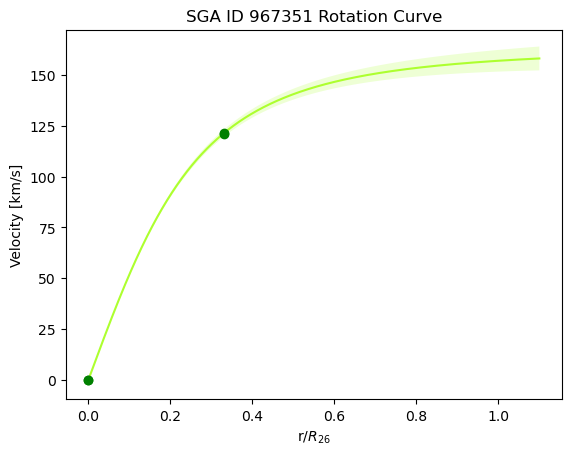

In [25]:
# Select a specific galaxy
sga_id = 967351
sga_idx = SGA_dict[sga_id]
axis_ratio = SGA['BA'][sga_idx]

# Calculate inclination and assign to table
inc = inclination_angle(axis_ratio)
tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = inc

# Apply velocity cut
v_cut = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]
radius = v_cut['SKY_FIBER_DIST_R26']
velocity = v_cut['VELOCITY']
velocity_err = v_cut['VERR']

# Separate center points (radius < 0.01) and outer points (radius >= 0.01)
center_mask = radius < 0.01
outer_mask = radius >= 0.01

# Process outer points
outer_velocity = velocity[outer_mask]
outer_radius = radius[outer_mask]
outer_velocity_err = velocity_err[outer_mask]

# Rolling median calculation for local trend
# Rolling median calculation for local trend (keeping window size)
window_size = 3  # Adjust if necessary
rolling_median = np.convolve(outer_velocity, np.ones(window_size) / window_size, mode='same')

# Adjust delta_v calculation to be less sensitive to neighboring outliers
delta_v = np.abs(np.diff(outer_velocity))  # One element shorter
delta_v = np.append(delta_v, delta_v[-1])  # Extend to match length of outer_velocity

# Identify outliers: Points that deviate significantly from rolling median and from their neighbors
# We use a dynamic threshold to ensure that neighboring points don’t trigger outlier flags
outlier_mask = (np.abs(outer_velocity - rolling_median) > 50) & (delta_v > 150)

# To handle the problem of neighbors, we ensure that the point being flagged as outlier is actually far from the local trend
# We can adjust this threshold to allow for points that are near but not dramatically off

# Manually check the problematic point (e.g., the point near 0.6) and include it
index_r_06 = np.where(np.abs(outer_radius - 0.6) < 0.01)[0]  # Find index near r ~ 0.6
outlier_mask[index_r_06] = False  # Manually set the outlier mask to False for this point

# Mask for valid points: Exclude points flagged as outliers
valid_outer_mask = ~outlier_mask

# Filter the outer points based on the adjusted mask
filtered_velocity = outer_velocity[valid_outer_mask]
filtered_radius = outer_radius[valid_outer_mask]
filtered_velocity_err = outer_velocity_err[valid_outer_mask]

# Combine center points and filtered outer points
center_points = v_cut[center_mask]
outer_points = v_cut[outer_mask][valid_outer_mask]
combined_cut = np.concatenate([center_points, outer_points])

# Extract final values for plotting
v = np.abs(combined_cut['VELOCITY'])
verr = combined_cut['VERR']
vrotate = v / np.sin(inc)
vrotate_err = verr / np.sin(inc)
radius_combined = combined_cut['SKY_FIBER_DIST_R26']

# Apply final mask for valid rotation velocities
mask = np.abs(vrotate) <= 1000
vrot = vrotate[mask]
vrot_err = vrotate_err[mask]
r = radius_combined[mask]

#initial guesses and bounds
alpha_guess = 2
alpha_low = 0.001
alpha_high = 4
v_max_guess = np.max(vrot)
v_max_low = 10
v_max_high = 1000
r_turn_guess = 0.3
r_turn_low = 0.25
r_turn_high = 1
    
#put guesses and bounds into array / tuples to pass into functions
guess = [v_max_guess, r_turn_guess, alpha_guess]
bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), (alpha_low, alpha_high)]
    
#define result
result = minimize(chi_2, guess, method = 'Powell', args=(vrot, vrot_err, r), bounds=bounds)
    
#plot only if result succeeds
if result.success:
    #calculating errors
    hessian = ndt.Hessian(chi_2)
    hess = hessian(result.x, vrot, vrot_err, r)
    np.save('/pscratch/sd/j/jjpim/hessians/' + str(sga_id) + '_hessian.npy', hess)
    try:
        hess_inv = 2*np.linalg.inv(hess)
        fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))
    except np.linalg.LinAlgError:
        fit_params_err = np.nan*np.ones(len(result.x))

    #adding results into table
    tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[0]
    tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[1]
    tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[2]
    #chi_normal = result.fun/(len(v)-3)
    tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.fun
        
    #adding errors to mastertable
    tf_mastertable['VMAX_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[0]
    tf_mastertable['RTURN_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[1]
    tf_mastertable['ALPHA_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[2]
        
    #create and index linear space
    rs = np.linspace(0, 1.1, 1000)
    vs = v_rot(rs, result.x[0], result.x[1], result.x[2])
            

    if not np.isnan(fit_params_err).all():
        N_samples = 10000
        try:
            random_sample = np.random.multivariate_normal(mean=[result.x[0],
                                                            result.x[1],
                                                            result.x[2]],
                                                            cov=hess_inv,
                                                            size=N_samples)
        except:
            print(str(sga_id) + ' plot sample failed')
            
        #cuts out bad samples in gaussian
        is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
        good_randoms = random_sample[is_good_random, :]
        
        
        y_sample = np.zeros((len(rs), len(good_randoms[:,0])))
        for i in range(len(rs)):
            for j in range(len(good_randoms[:,0])):
        # Calculate values of curve at this location
                y_sample[i][j] = v_rot(rs[i], good_randoms[:,0][j],
                                              good_randoms[:,1][j],
                                              good_randoms[:,2][j])
        
        #standard dev along axis of parameter variances
        stdevs = np.nanstd(y_sample, axis=1)   
        
        plt.fill_between(rs, vs - stdevs, vs + stdevs, facecolor='greenyellow', alpha=0.2)
        
    plt.errorbar(r, vrot, yerr=vrot_err, linestyle='none', marker='o', color='g')
    plt.plot(rs, vs, color='greenyellow')
    plt.xlabel(r"r/$R_{26}$")
    plt.ylabel("Velocity [km/s]")
    plt.title("SGA ID "+str(sga_id)+ " Rotation Curve")
    img_name = v_dir + '{}.jpg'.format(sga_id)
    plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
    plt.show()
    plt.close()

In [ ]:
#check table for individual SGA ID
tf_mastertable[tf_mastertable['SGA_ID']==608015]

In [121]:
#writing new data into new table
tf_mastertable.write(data_dir + 'tf_mastertable.fits', format='fits', overwrite=True)